# Определение возраста людей по фотографии

В данном проекте обучим нейронную сеть предсказывать возраст человека по фотографии.

В качестве метрики будем использовать среднее абсолютное отклонение MAE

$$
MAE = \sum_{i=1}^{N}|y_~-y_i|
$$

## Исследовательский анализ данных

Импорт библиотек:

In [1]:
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_color_codes('muted')
sns.set_style('ticks', {'axes.grid': 'True'})

Импорт датасета:

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Датасет содержит название изображения и возраст человека на изображении

In [4]:
labels.shape

(7591, 2)

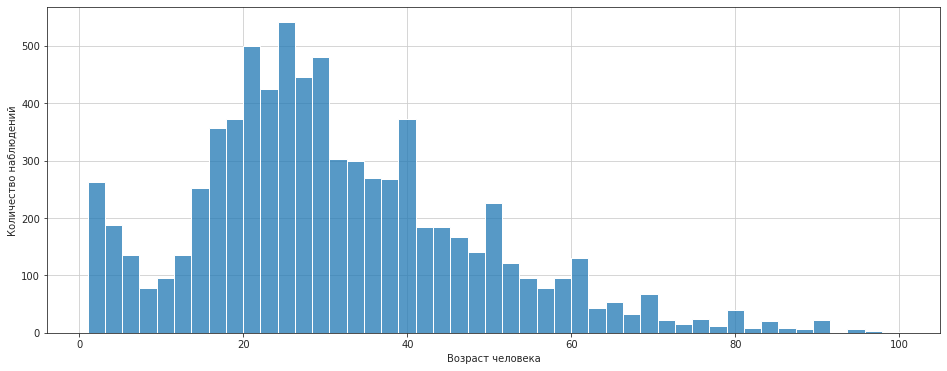

In [5]:
plt.figure(figsize=(16,6))
sns.histplot(labels.real_age)
plt.ylabel('Количество наблюдений')
plt.xlabel('Возраст человека')
plt.show()

In [6]:
labels.real_age.describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Всего в датасете 7591 изображение, возвраст людей на фото от 1 года до 100 лет, в среднем человеку на фото 29 лет.

In [7]:
features = next(train_gen_flow)[0]

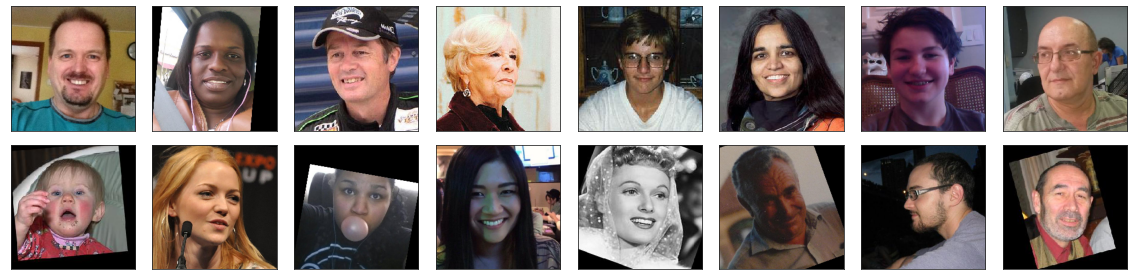

In [8]:
fig = plt.figure(figsize=(16,4))
for i in range(16):
    fig.add_subplot(2, 8, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Можно заметить, что сами фотографии бывают как уменьшенные, повернутые, сдвинутые и т.д., так же сами люди на фотографиях могут смотреть не только в камеру, но и в стороны, улыбаться, показывать различные эмоции.

## Обучение модели на GPU

Саму нейронную сеть обучим на удаленном сервере, функции для обучения:
1. load_train(path) - загрузка данных и создание объекта ImageDataGenerator, в один батч будем помещать 16 изображений  
Так же проводим аугментацию изображений:
* все пиксели изображений приводим к одному масштабу от 0 до 1
* добавляем горизонтальное отображение, вертикальное отображение в данном случае бессмысленно
2. load_test(path) - загрузка тестового датасета и создание объекта ImageDataGenerator
3. create_model(input_shape) - создание модели  
В данном случае будем использовать предобученную на датасете Imagenet модель ResNet101, в качестве оптимизатора используем алгоритм Adam со скоростью обучения 1e-4, в качестве лосс-функции используем MSE, т.к. с данным лосом модель обучается значительно быстрее, метрика - MAE  
Выходной слой содержит в себе 1 нейрон, с функцией активации ReLU. ReLU в данном случае необходима для того, чтобы модель предсказывала только положительные значения.
4. train_model(args) - функция для обучения модели, в данном случае установим 10 эпох для обучения модели.

In [9]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    
    backbone = ResNet101(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

Прогресс обучения:

```
Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 69s - loss: 190.8561 - mae: 10.0831 - val_loss: 439.3938 - val_mae: 15.8468
Epoch 2/10
356/356 - 51s - loss: 81.9830 - mae: 6.9073 - val_loss: 156.9328 - val_mae: 9.9817
Epoch 3/10
356/356 - 51s - loss: 62.5379 - mae: 6.0347 - val_loss: 104.4067 - val_mae: 7.7155
Epoch 4/10
356/356 - 51s - loss: 44.1349 - mae: 5.0793 - val_loss: 80.5897 - val_mae: 6.9176
Epoch 5/10
356/356 - 51s - loss: 32.5026 - mae: 4.3705 - val_loss: 73.2344 - val_mae: 6.3692
Epoch 6/10
356/356 - 51s - loss: 27.1114 - mae: 3.9270 - val_loss: 139.8954 - val_mae: 9.6991
Epoch 7/10
356/356 - 52s - loss: 20.9668 - mae: 3.4967 - val_loss: 73.3366 - val_mae: 6.4457
Epoch 8/10
356/356 - 51s - loss: 18.0857 - mae: 3.1924 - val_loss: 68.3262 - val_mae: 6.1892
Epoch 9/10
356/356 - 52s - loss: 14.1894 - mae: 2.9038 - val_loss: 61.5897 - val_mae: 5.8817
Epoch 10/10
356/356 - 50s - loss: 13.4120 - mae: 2.7590 - val_loss: 62.3703 - val_mae: 5.9850
```

Тестирование модели:

```
119/119 - 10s - loss: 62.3703 - mae: 5.9850
Test MAE: 5.9850
```

В результате, на тестовой выборке получена ошибка MAE равная 6 годам, в оригинальной статье получена ошибка MAE=5.4 годам.
Ссылка на статью: http://people.ee.ethz.ch/~timofter/publications/Agustsson-FG-2017.pdf